## Импорты

In [1]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

## Подготовка данных

In [2]:
data_path = '../data/processed/context_answer.csv'
df = pd.read_csv(data_path)

# Фильтрация данных
min_length = 3
max_length = 50
df = df[(df['context'].str.split().str.len().between(min_length, max_length)) & 
        (df['response'].str.split().str.len().between(min_length, max_length))]

## Подготовка модели

In [3]:
# Инициализация токенизатора с дополнительным токеном
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
sep_token = '<|sep|>'
tokenizer.add_special_tokens({'additional_special_tokens': [sep_token]})
tokenizer.pad_token = tokenizer.eos_token


def create_sequences(row):
    """Создание объединенных последовательностей"""
    return f"{row['context']} {sep_token} {row['response']}{tokenizer.eos_token}"

df['sequence'] = df.apply(create_sequences, axis=1)

# Разделение данных
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Класс Dataset
class ConversationDataset(Dataset):
    def __init__(self, sequences, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = tokenizer(
            sequences.tolist(),
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_tensors='pt'
        )

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['input_ids'][idx].clone()
        }

# Создание Dataset и DataLoader
train_dataset = ConversationDataset(train_df['sequence'], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Инициализация модели
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

# Заморозка слоев
for param in model.parameters():
    param.requires_grad = False
for param in model.transformer.h[-4:].parameters():
    param.requires_grad = True

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


## Обучение модели

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████| 1188/1188 [00:50<00:00, 23.46it/s, loss=4.88]


Epoch 1 Average Loss: 3.9941


Epoch 2: 100%|███████████████████████████████████████████████████████████| 1188/1188 [00:50<00:00, 23.33it/s, loss=3.57]


Epoch 2 Average Loss: 3.8377


Epoch 3: 100%|███████████████████████████████████████████████████████████| 1188/1188 [00:51<00:00, 23.24it/s, loss=3.25]


Epoch 3 Average Loss: 3.7444


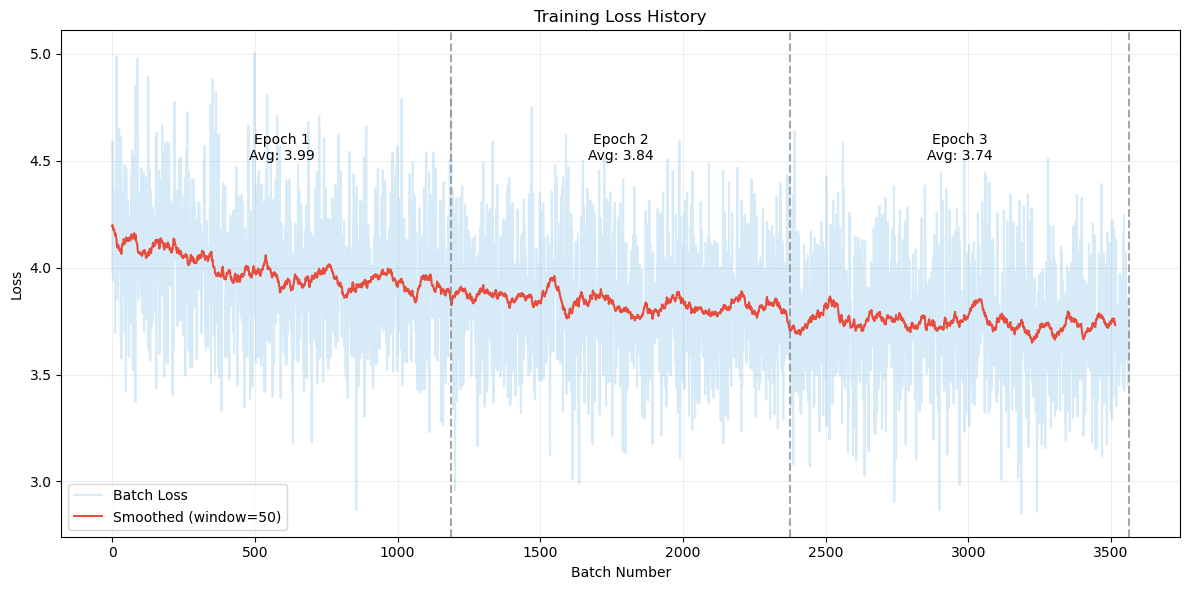

In [4]:
# Настройка обучения
optimizer = AdamW(model.parameters(), lr=3e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Инициализация списков для отслеживания потерь
all_losses = []          # Потери на каждом батче
epoch_losses = []        # Средние потери по эпохам

# Обучение с прогресс-баром
for epoch in range(3):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        inputs = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Маскировка loss для части контекста
        labels[inputs == tokenizer.pad_token_id] = -100
        sep_positions = (inputs == tokenizer.convert_tokens_to_ids(sep_token)).nonzero()[:,1]
        for i, pos in enumerate(sep_positions):
            labels[i, :pos+1] = -100
        
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_losses.append(loss.item())  # Сохраняем loss каждого батча
        progress_bar.set_postfix({'loss': loss.item()})
    
    epoch_avg_loss = total_loss/len(train_loader)
    epoch_losses.append(epoch_avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {epoch_avg_loss:.4f}")

# Визуализация обучения
plt.figure(figsize=(12, 6))

# Сырые данные и сглаженная кривая
window_size = 50  # Размер окна для скользящего среднего
smoothed_losses = np.convolve(
    all_losses, 
    np.ones(window_size)/window_size, 
    mode='valid'
)

plt.plot(all_losses, alpha=0.2, label='Batch Loss', color='#3498db')
plt.plot(smoothed_losses, label=f'Smoothed (window={window_size})', color='#e74c3c')

# Разметка эпох
num_batches_per_epoch = len(train_loader)
for epoch in range(3):
    end_batch = (epoch + 1) * num_batches_per_epoch
    plt.axvline(end_batch, color='grey', linestyle='--', alpha=0.7)
    plt.text(
        end_batch - num_batches_per_epoch/2, 
        max(all_losses)*0.9, 
        f'Epoch {epoch+1}\nAvg: {epoch_losses[epoch]:.2f}',
        ha='center'
    )

plt.title('Training Loss History')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


def generate_response(model, tokenizer, context, max_length=50):
    """Функция генерации ответа"""
    prompt = f"{context} {sep_token}"
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    
    output = model.generate(
        inputs.input_ids,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        num_return_sequences=1,
        no_repeat_ngram_size=2  # Блокировка повторяющихся n-грамм
    )
    
    full_text = tokenizer.decode(output[0], skip_special_tokens=False)
    response = full_text.split(sep_token)[-1].split(tokenizer.eos_token)[0].strip()
    return response
    

## Сохранение модели и токенизатора

In [5]:
model.save_pretrained('../trained_model/')
tokenizer.save_pretrained('../trained_tokenizer/')

('../trained_tokenizer/tokenizer_config.json',
 '../trained_tokenizer/special_tokens_map.json',
 '../trained_tokenizer/vocab.json',
 '../trained_tokenizer/merges.txt',
 '../trained_tokenizer/added_tokens.json')